# Fully-saturated TWFE

In [311]:
import re
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from patsy import dmatrix

import pymc as pm
import pymc_experimental.statespace.models.structural as st
import pytensor.tensor as pt
import arviz as az
az.style.use('arviz-darkgrid')

rng = np.random.default_rng(42)
figsize = (10, 5)

In [312]:
filepath = '../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)
df = df.dropna(subset=['population'])
df.loc[df['treatment_group'] == 0, 'time_since_treatment'] = np.nan # コントロール群の処置後経過年数は欠損値
df['time_since_treatment'] = np.nan_to_num(df['time_since_treatment'], nan=1000)

df.island_ids = df.island_ids.astype(str)
df.island_ids = df.island_ids.map(str.strip)
island_id, mn_island_ids = df.island_ids.factorize()

df.bridge_year = df.bridge_year.astype(str)
df.bridge_year = df.bridge_year.map(str.strip)
bridge_year, mn_bridge_years = df.bridge_year.factorize()

$$
\begin{aligned}
\log{Y^{**}_{it}} &\sim \mathcal{t} (\nu, \mu_{it}, \sigma_i^2) \\
\nu &\sim \text{Exponential}(1/10) \\
\mu_{it} &= \alpha + \beta_{gl} \cdot T_{i} \\
\alpha &\sim \mathcal{N}(0, 0.1^2) \\
\beta_{gl} &\sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta}^2) \\
\sigma_i &\sim \mathcal{C}^+(\sigma_0^2) \\
\end{aligned}
$$

- $\beta_{gl}$: 介入時期 $g$ と介入経過時間 $l$ によって変動する介入効果
- $T_{it}$: 介入群ダミー
- $\mu_{\beta} \sim N(0, 0.3^2)$: 介入時期と介入経過時間の期待値を表すハイパーパラメータ
- $\sigma_{\beta}^2 \sim N^+(0.3^2)$: 介入時期と介入経過時間の分散を表すハイパーパラメータ
- $\sigma_0^2 \sim N^+(0.24^2)$: 島間の誤差分散を表すハイパーパラメータ
- $\sigma_i^2$: 島間の誤差分散

## サンプリングのインポート

In [3]:
trace_homo = az.from_netcdf('./mcmc_sample/fully_saturated/homo_20250111.nc')
# beta_df = pd.read_csv('../../data/processed/fully_saturated/homo.csv')

## 階層ベイズモデル 不均一分散

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


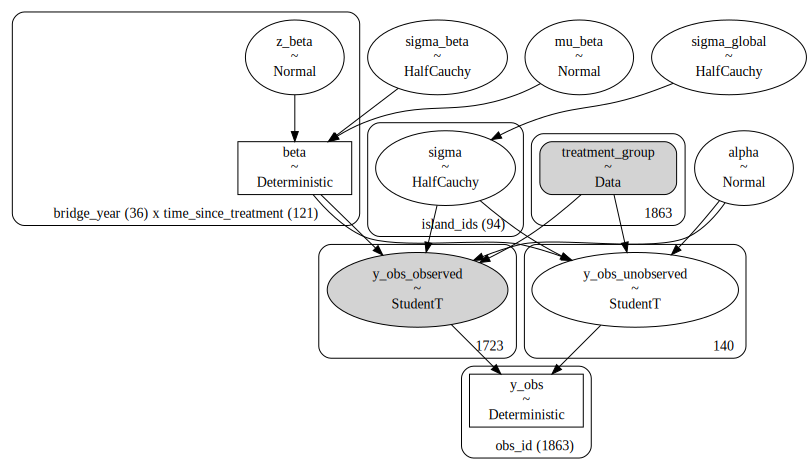

In [4]:
COORDS = {
    'obs_id': df.index,
    'island_ids': mn_island_ids,
    'bridge_year': mn_bridge_years,
    'time_since_treatment': mn_time_since_treatments,
}

with pm.Model(coords=COORDS) as model_h_hetero:
    # data
    # island_ids = pm.Data('island_ids', island_ids)
    # bridge_year = pm.Data('bridge_year', bridge_year)
    treatment_group = pm.Data('treatment_group', df['treatment_group'])
    # time_since_treatment = pm.Data('time_since_treatment', time_since_treatment)

    # priors
    # ATT
    mu_beta = pm.Normal('mu_beta', mu=0, sigma=0.1)
    sigma_beta = pm.HalfCauchy('sigma_beta', 0.1)
    z_beta = pm.Normal('z_beta', mu=0, sigma=1, dims=('bridge_year', 'time_since_treatment'))
    beta = pm.Deterministic('beta', mu_beta + sigma_beta * z_beta, dims=('bridge_year', 'time_since_treatment'))

    # sigma
    sigma_global = pm.HalfCauchy('sigma_global', 0.15)
    sigma = pm.HalfCauchy('sigma', sigma_global, dims='island_ids')

    # fixed effects
    alpha = pm.Normal('alpha', mu=0, sigma=0.1)
    nu = 7

    # expected value
    mu = alpha + beta[bridge_year, time_since_treatment] * treatment_group

    # likelihood
    y_obs = pm.StudentT('y_obs', mu=mu, sigma=sigma[island_id], nu=nu, observed=df['log_pop_star'], dims='obs_id')

pm.model_to_graphviz(model_h_hetero)

In [5]:
with model_h_hetero:
    trace_h_hetero = pm.sample(
        draws=2500,
        tune=1000,
        chains=4,
        cores=4,
        nuts_sampler='numpyro',
        random_seed=rng,
        target_accept=0.95, # これを設定しないとチェーンが動かない
    )

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [1]:
trace_h_hetero = az.from_netcdf('./mcmc_sample/fully_saturated/hie_hetero_const_20250108.nc')

NameError: name 'az' is not defined

In [1]:
# サンプリングの保存
az.to_netcdf(trace_h_hetero, './mcmc_sample/fully_saturated/hie_hetero_const_20250108.nc')

NameError: name 'az' is not defined

In [7]:
az.summary(trace_h_hetero, var_names=['alpha', 'mu_beta', 'sigma_beta', 'sigma_global',], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.024,0.004,0.017,0.031,0.000,0.0,340.0,469.0,1.02
mu_beta,-0.055,0.009,-0.072,-0.038,0.000,0.0,366.0,1046.0,1.11
sigma_beta,0.123,0.007,0.110,0.139,0.001,0.0,128.0,137.0,1.05
sigma_global,0.135,0.017,0.104,0.171,0.001,0.0,760.0,2742.0,1.06


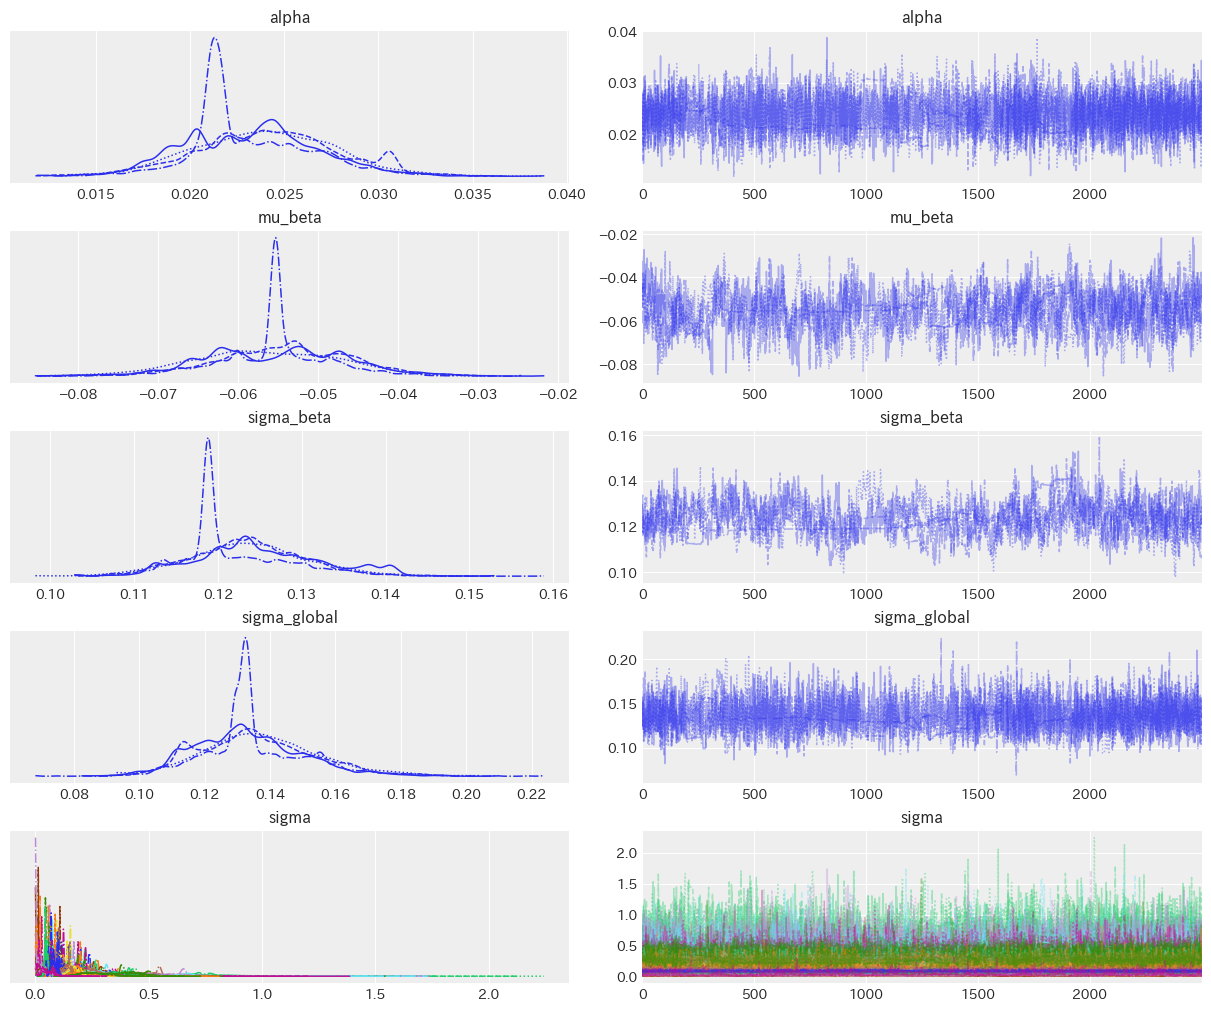

In [8]:
az.plot_trace(trace_h_hetero, var_names=['alpha', 'mu_beta', 'sigma_beta', 'sigma_global', 'sigma']);

## 階層ベイズモデル 均一分散

In [3]:
bridge_year_list = df['bridge_year'].unique()
bridge_year_list.sort()
bridge_year_list

array(['0', '1970', '1972', '1973', '1975', '1976', '1979', '1982',
       '1983', '1987', '1988', '1989', '1991', '1992', '1995', '1996',
       '1997', '1998', '1999', '2000', '2004', '2008', '2011', '2015',
       '2016'], dtype=object)

In [61]:
fully_saturated = dmatrix('C(bridge_year):C(time_since_treatment) - 1', df, return_type='dataframe')
fully_saturated = fully_saturated.loc[:, (fully_saturated != 0).any(axis=0)] # 全て0の列を削除
fully_saturated.drop(
    columns=['C(bridge_year)[0]:C(time_since_treatment)[1000.0]'], # コントロール群を削除
    axis=1, inplace=True
)
fully_saturated

,C(bridge_year)[2016]:C(time_since_treatment)[-46.0],C(bridge_year)[2015]:C(time_since_treatment)[-45.0],C(bridge_year)[2011]:C(time_since_treatment)[-41.0],C(bridge_year)[2016]:C(time_since_treatment)[-41.0],C(bridge_year)[2015]:C(time_since_treatment)[-40.0],C(bridge_year)[2011]:C(time_since_treatment)[-36.0],C(bridge_year)[2016]:C(time_since_treatment)[-36.0],C(bridge_year)[2015]:C(time_since_treatment)[-35.0],C(bridge_year)[2004]:C(time_since_treatment)[-34.0],C(bridge_year)[2008]:C(time_since_treatment)[-33.0],...,C(bridge_year)[1975]:C(time_since_treatment)[40.0],C(bridge_year)[1979]:C(time_since_treatment)[41.0],C(bridge_year)[1973]:C(time_since_treatment)[42.0],C(bridge_year)[1972]:C(time_since_treatment)[43.0],C(bridge_year)[1976]:C(time_since_treatment)[44.0],C(bridge_year)[1970]:C(time_since_treatment)[45.0],C(bridge_year)[1975]:C(time_since_treatment)[45.0],C(bridge_year)[1973]:C(time_since_treatment)[47.0],C(bridge_year)[1972]:C(time_since_treatment)[48.0],C(bridge_year)[1970]:C(time_since_treatment)[50.0]
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


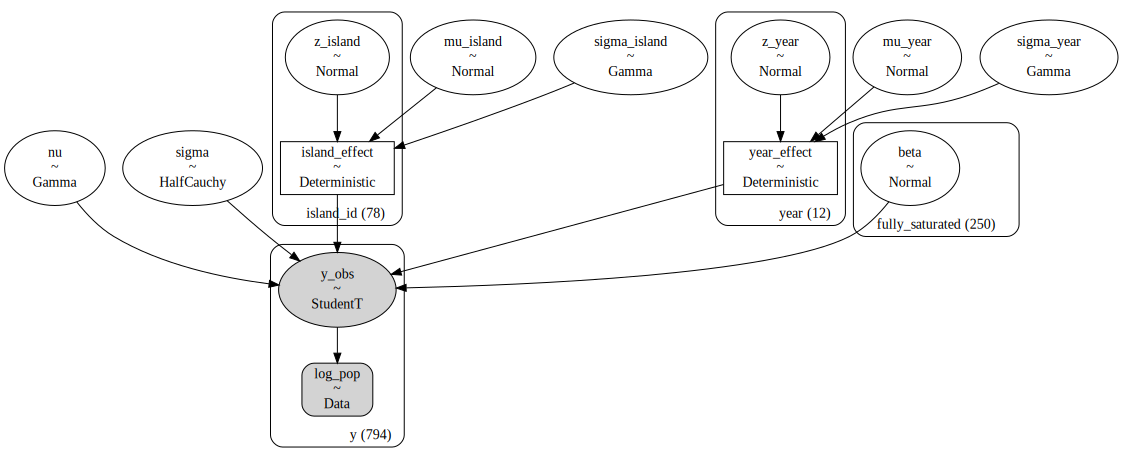

In [6]:
# 年をダミー化
year_dummies = dmatrix('C(year)-1', df, return_type='dataframe')
year_dummies.drop('C(year)[1960]', axis=1, inplace=True)
COORDS = {
    'y': df.index,
    'X': df.index,
    'island_id': mn_island_ids,
    'year': year_dummies.columns,
    'fully_saturated': fully_saturated.columns,
}

with pm.Model(coords=COORDS) as model_homo:
    # data
    log_pop = pm.Data('log_pop', df['log_pop'], dims='y')
    year = pm.Data('year', df['year'], dims='X')
    # treatment_group = pm.Data('treatment_group', df['treatment_group'], dims='X')
    # after_treatment = pm.Data('after_treatment', df['after_treatment'], dims='X')

    # priors
    # random effect
    mu_island = pm.Normal('mu_island', mu=5, sigma=1)
    sigma_island = pm.Gamma('sigma_island', alpha=3, beta=1)
    z_island = pm.Normal('z_island', mu=0, sigma=1, dims='island_id')
    island_effect = pm.Deterministic('island_effect', mu_island + sigma_island * z_island, dims='island_id')

    # mu_year = pm.Normal('mu_year', mu=-0.1, sigma=1)
    # sigma_year = pm.Gamma('sigma_year', alpha=2, beta=1)
    # z_year = pm.Normal('z_year', mu=0, sigma=1, dims='year')
    # year_effect = pm.Deterministic('year_effect', mu_year + sigma_year * z_year, dims='year')
    year_effect = pm.Normal('year_effect', mu=-1, sigma=1, dims='year')

    # fixed effect
    beta = pm.Normal('beta', mu=0, sigma=1, dims='fully_saturated')
    gamma = pm.Normal('gamma', mu=0, sigma=1, dims='island_id')
    sigma = pm.HalfCauchy('sigma', beta=1)
    nu = pm.Gamma('nu', alpha=2, beta=0.1)

    # expectation
    mu = pm.math.dot(fully_saturated, beta) + island_effect[island_id] + pm.math.dot(year_dummies, year_effect) + gamma[island_id] * year

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma, observed=log_pop, dims='y')

pm.model_to_graphviz(model_homo)

In [7]:
with model_homo:
    trace_homo = pm.sample(
        draws=2000,
        tune=2000,
        chains=4,
        cores=4,
        nuts_sampler='numpyro',
        random_seed=rng,
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [8]:
az.to_netcdf(trace_homo, './mcmc_sample/fully_saturated/homo_20250111.nc')

'./mcmc_sample/fully_saturated/homo_20250111.nc'

In [9]:
az.summary(trace_homo, var_names=['sigma', 'nu', 'mu_island', 'sigma_island', 'mu_year', 'sigma_year'], hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.137,0.011,0.116,0.160,0.000,0.000,2192.0,3770.0,1.0
nu,2.446,0.374,1.766,3.181,0.006,0.005,3402.0,5205.0,1.0
mu_island,5.930,0.490,4.968,6.890,0.008,0.005,4080.0,4065.0,1.0
sigma_island,1.975,0.164,1.674,2.311,0.004,0.003,1916.0,3461.0,1.0
mu_year,-0.193,0.481,-1.112,0.762,0.006,0.005,7340.0,4621.0,1.0
sigma_year,0.626,0.159,0.372,0.946,0.002,0.002,5119.0,5257.0,1.0


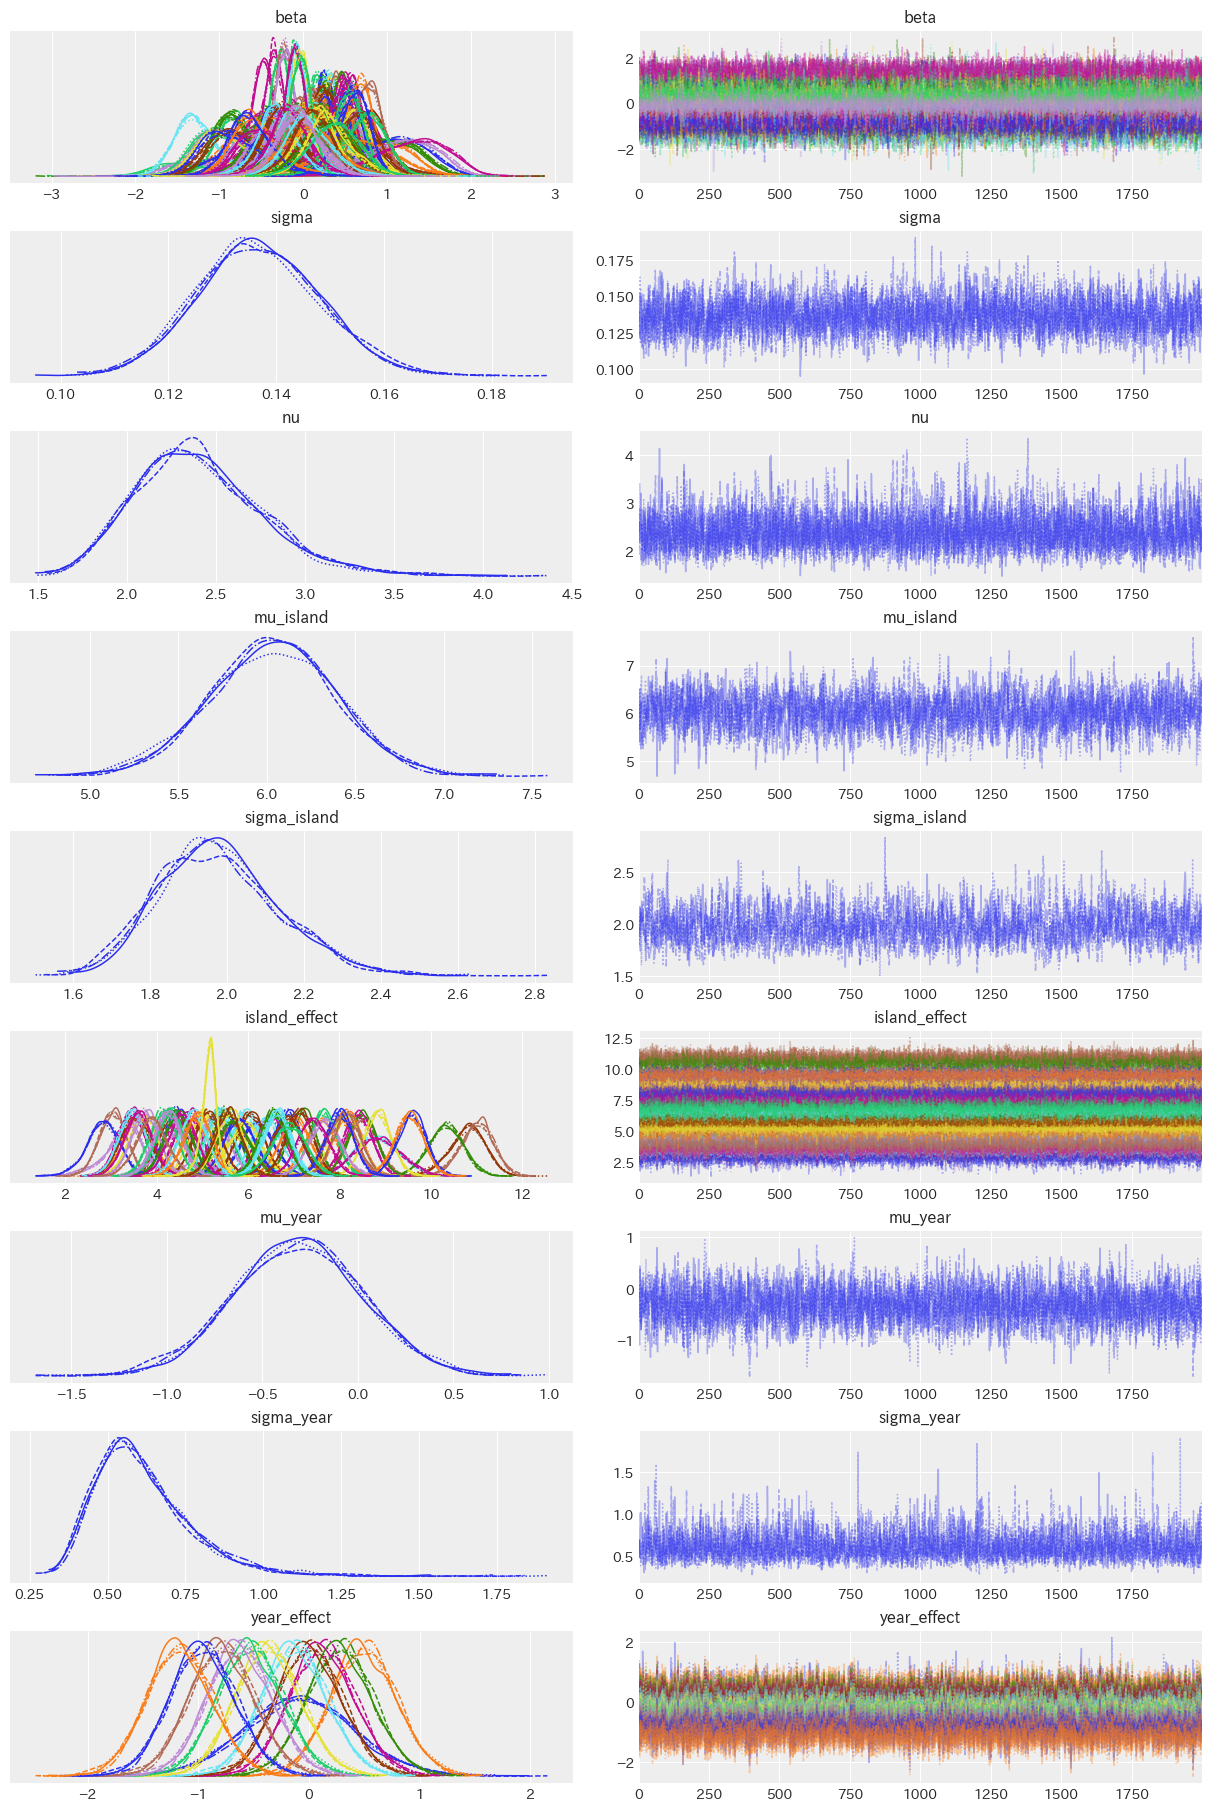

In [16]:
az.plot_trace(trace_homo, var_names=['beta', 'sigma', 'nu', 'mu_island', 'sigma_island', 'island_effect', 'mu_year', 'sigma_year', 'year_effect']);

In [31]:
with model_homo:
    pm.compute_log_likelihood(trace_homo)

Output()

In [32]:
az.waic(trace_homo)

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 8000 posterior samples and 782 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -164.36    30.48
p_waic      375.17        -

There has been a warning during the calculation. Please check the results.

## ウェイトの計算

In [6]:
posterior = trace_homo.posterior
beta_samples = posterior['beta'].stack(dims=('chain', 'draw'))

In [21]:
beta_pd = pd.DataFrame

<xarray.DataArray 'beta' (fully_saturated: 250, dims: 8000)> Size: 16MB
array([[ 0.34566099, -0.17398356, -0.12377691, ..., -0.78150678,
        -1.09049087, -0.55238224],
       [-0.26685125,  0.6342482 , -0.63307626, ..., -0.10964451,
        -0.20268461, -0.58778672],
       [ 0.15712469, -0.88485361, -0.89191378, ..., -0.39944727,
         0.44771371, -0.35653022],
       ...,
       [ 0.09318922,  0.93375628,  0.1074139 , ...,  1.39428873,
         1.16235011,  0.66829702],
       [-0.13344625,  1.28332842,  0.23144375, ...,  0.51034743,
         0.42429538,  0.21315527],
       [-0.04900114, -0.08276196, -0.4524291 , ...,  0.22455946,
         0.11316307,  0.48914165]])
Coordinates:
  * fully_saturated  (fully_saturated) <U51 51kB 'C(bridge_year)[2016]:C(time...
  * dims             (dims) object 64kB MultiIndex
  * chain            (dims) int64 64kB 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3
  * draw             (dims) int64 64kB 0 1 2 3 4 5 ... 1995 1996 1997 1998 1999

In [25]:
fully_saturated = dmatrix('C(bridge_year):C(time_since_treatment) - 1', df, return_type='dataframe')
fully_saturated = fully_saturated.loc[:, (fully_saturated != 0).any(axis=0)] # 全て0の列を削除
fully_saturated.drop(
    columns=['C(bridge_year)[0]:C(time_since_treatment)[1000.0]'], # コントロール群を削除
    axis=1, inplace=True
)
beta_pd = pd.DataFrame(beta_samples.T, columns=fully_saturated.columns)

In [28]:
beta_pd

,C(bridge_year)[2016]:C(time_since_treatment)[-46.0],C(bridge_year)[2015]:C(time_since_treatment)[-45.0],C(bridge_year)[2011]:C(time_since_treatment)[-41.0],C(bridge_year)[2016]:C(time_since_treatment)[-41.0],C(bridge_year)[2015]:C(time_since_treatment)[-40.0],C(bridge_year)[2011]:C(time_since_treatment)[-36.0],C(bridge_year)[2016]:C(time_since_treatment)[-36.0],C(bridge_year)[2015]:C(time_since_treatment)[-35.0],C(bridge_year)[2004]:C(time_since_treatment)[-34.0],C(bridge_year)[2008]:C(time_since_treatment)[-33.0],...,C(bridge_year)[1975]:C(time_since_treatment)[40.0],C(bridge_year)[1979]:C(time_since_treatment)[41.0],C(bridge_year)[1973]:C(time_since_treatment)[42.0],C(bridge_year)[1972]:C(time_since_treatment)[43.0],C(bridge_year)[1976]:C(time_since_treatment)[44.0],C(bridge_year)[1970]:C(time_since_treatment)[45.0],C(bridge_year)[1975]:C(time_since_treatment)[45.0],C(bridge_year)[1973]:C(time_since_treatment)[47.0],C(bridge_year)[1972]:C(time_since_treatment)[48.0],C(bridge_year)[1970]:C(time_since_treatment)[50.0]
0,0.345661,-0.266851,0.157125,-0.070188,-0.676537,0.126675,-0.002490,-0.127206,-0.450360,-0.350071,...,0.184012,-0.148829,0.044599,0.162556,0.425283,-0.222450,0.293217,0.093189,-0.133446,-0.049001
1,-0.173984,0.634248,-0.884854,0.421423,0.909470,0.075553,0.296223,1.028313,-0.006378,-0.003037,...,0.511542,-0.053028,0.786334,1.381266,0.438630,-0.082650,0.175989,0.933756,1.283328,-0.082762
2,-0.123777,-0.633076,-0.891914,-0.291334,-0.481506,0.296006,0.066747,-0.648047,-0.256492,-0.148032,...,0.189555,0.575273,0.200925,0.479597,0.422316,-0.604900,-0.181511,0.107414,0.231444,-0.452429
3,-0.372964,-0.531180,-0.859367,-0.007219,-0.589793,-0.086449,-0.117096,-0.314503,-0.293169,-0.108598,...,-0.092499,0.493446,-0.461700,0.098173,0.405227,-0.686168,-0.094367,-0.087476,-0.066332,-0.518483
4,-0.317434,-1.000844,-0.761101,-0.100687,-0.780698,-0.432357,0.069063,-0.391812,-0.649691,0.304341,...,0.585061,0.559882,-0.409134,-0.369339,0.736357,-0.347710,0.647198,0.383194,-0.047669,-0.538459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,-0.996566,-0.560195,-0.503282,-0.446376,-0.533124,-0.365795,-0.525181,-0.535987,-0.118965,-0.172200,...,0.604190,0.199940,0.707815,0.808227,0.606431,0.281458,0.304658,0.891610,0.670348,0.222059
7996,-0.816757,-0.399564,-0.296392,-0.763328,-0.613253,-0.219189,-0.689915,0.006420,-0.637599,-0.035009,...,0.815790,0.338052,0.866112,0.490308,0.715356,-0.104260,0.033755,1.340100,0.308391,-0.195724
7997,-0.781507,-0.109645,-0.399447,-0.606759,-0.472803,-0.154531,-0.637965,-0.211751,-0.574364,0.074344,...,-0.027410,0.245608,0.964599,0.632635,0.633720,-0.242240,-0.289224,1.394289,0.510347,0.224559
7998,-1.090491,-0.202685,0.447714,-0.739140,-0.310327,0.728274,-0.651805,-0.025152,-0.514750,0.403851,...,-0.523583,0.120453,0.971593,0.672599,0.912365,0.359351,-0.245582,1.162350,0.424295,0.113163


In [93]:
ell_list = df['time_since_treatment'].unique()
ell_list.sort()
ell_list[0:-1]

array([-46., -45., -41., -40., -36., -35., -34., -33., -31., -30., -29.,
       -28., -26., -25., -24., -23., -22., -21., -20., -19., -18., -17.,
       -16., -15., -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,
        -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,
         6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,
        17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,
        28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,
        39.,  40.,  41.,  42.,  43.,  44.,  45.,  47.,  48.,  50.])

In [96]:
beta_pd

,C(bridge_year)[2016]:C(time_since_treatment)[-46.0],C(bridge_year)[2015]:C(time_since_treatment)[-45.0],C(bridge_year)[2011]:C(time_since_treatment)[-41.0],C(bridge_year)[2016]:C(time_since_treatment)[-41.0],C(bridge_year)[2015]:C(time_since_treatment)[-40.0],C(bridge_year)[2011]:C(time_since_treatment)[-36.0],C(bridge_year)[2016]:C(time_since_treatment)[-36.0],C(bridge_year)[2015]:C(time_since_treatment)[-35.0],C(bridge_year)[2004]:C(time_since_treatment)[-34.0],C(bridge_year)[2008]:C(time_since_treatment)[-33.0],...,C(bridge_year)[1975]:C(time_since_treatment)[40.0],C(bridge_year)[1979]:C(time_since_treatment)[41.0],C(bridge_year)[1973]:C(time_since_treatment)[42.0],C(bridge_year)[1972]:C(time_since_treatment)[43.0],C(bridge_year)[1976]:C(time_since_treatment)[44.0],C(bridge_year)[1970]:C(time_since_treatment)[45.0],C(bridge_year)[1975]:C(time_since_treatment)[45.0],C(bridge_year)[1973]:C(time_since_treatment)[47.0],C(bridge_year)[1972]:C(time_since_treatment)[48.0],C(bridge_year)[1970]:C(time_since_treatment)[50.0]
0,0.345661,-0.266851,0.157125,-0.070188,-0.676537,0.126675,-0.002490,-0.127206,-0.450360,-0.350071,...,0.184012,-0.148829,0.044599,0.162556,0.425283,-0.222450,0.293217,0.093189,-0.133446,-0.049001
1,-0.173984,0.634248,-0.884854,0.421423,0.909470,0.075553,0.296223,1.028313,-0.006378,-0.003037,...,0.511542,-0.053028,0.786334,1.381266,0.438630,-0.082650,0.175989,0.933756,1.283328,-0.082762
2,-0.123777,-0.633076,-0.891914,-0.291334,-0.481506,0.296006,0.066747,-0.648047,-0.256492,-0.148032,...,0.189555,0.575273,0.200925,0.479597,0.422316,-0.604900,-0.181511,0.107414,0.231444,-0.452429
3,-0.372964,-0.531180,-0.859367,-0.007219,-0.589793,-0.086449,-0.117096,-0.314503,-0.293169,-0.108598,...,-0.092499,0.493446,-0.461700,0.098173,0.405227,-0.686168,-0.094367,-0.087476,-0.066332,-0.518483
4,-0.317434,-1.000844,-0.761101,-0.100687,-0.780698,-0.432357,0.069063,-0.391812,-0.649691,0.304341,...,0.585061,0.559882,-0.409134,-0.369339,0.736357,-0.347710,0.647198,0.383194,-0.047669,-0.538459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,-0.996566,-0.560195,-0.503282,-0.446376,-0.533124,-0.365795,-0.525181,-0.535987,-0.118965,-0.172200,...,0.604190,0.199940,0.707815,0.808227,0.606431,0.281458,0.304658,0.891610,0.670348,0.222059
7996,-0.816757,-0.399564,-0.296392,-0.763328,-0.613253,-0.219189,-0.689915,0.006420,-0.637599,-0.035009,...,0.815790,0.338052,0.866112,0.490308,0.715356,-0.104260,0.033755,1.340100,0.308391,-0.195724
7997,-0.781507,-0.109645,-0.399447,-0.606759,-0.472803,-0.154531,-0.637965,-0.211751,-0.574364,0.074344,...,-0.027410,0.245608,0.964599,0.632635,0.633720,-0.242240,-0.289224,1.394289,0.510347,0.224559
7998,-1.090491,-0.202685,0.447714,-0.739140,-0.310327,0.728274,-0.651805,-0.025152,-0.514750,0.403851,...,-0.523583,0.120453,0.971593,0.672599,0.912365,0.359351,-0.245582,1.162350,0.424295,0.113163


In [202]:
beta_ell_df = pd.DataFrame()

ell_list = df['time_since_treatment'].unique()
ell_list.sort()
ell_list[0:-1]

for ell in ell_list:
    pattern = re.compile(rf'\[{ell}\]$')
    # 'ell'を含むカラムを選択
    selected_columns = beta_pd.columns[beta_pd.columns.str.contains(pattern)]
    if selected_columns.empty:
        print(f"No columns found for pattern: {pattern}")
        continue
    beta_ell = beta_pd[selected_columns]
    new_param_samples = beta_ell.sum(axis=1) / beta_ell.shape[1]
    beta_ell_df[f'ell_{ell}'] = new_param_samples

No columns found for pattern: re.compile('\\[1000.0\\]$')


In [215]:
beta_ell_df.to_csv('../../data/processed/fully_saturated/weighted_beta_posterior.csv', index=False)

In [205]:
fs_df = pd.DataFrame()
fs_df['mean'] = beta_ell_df.mean()
fs_df['sd'] = beta_ell_df.std()
fs_df['hdi_lw'] = beta_ell_df.quantile(0.025)
fs_df['hdi_up'] = beta_ell_df.quantile(0.975)
fs_df['ell'] = ell_list[0:-1]

In [227]:
ell = -3.0

pattern = re.compile(rf'\[{ell}\]$')
# 'ell'を含むカラムを選択
selected_columns = beta_pd.columns[beta_pd.columns.str.contains(pattern)]
if selected_columns.empty:
    print(f"No columns found for pattern: {pattern}")
beta_ell = beta_pd[selected_columns]
print(beta_ell.shape[1])
new_param_samples = beta_ell.sum(axis=1) / beta_ell.shape[1]


5


In [216]:
fs_df.to_csv('../../data/processed/fully_saturated/weighted_beta_posterior_summary.csv', index=False)

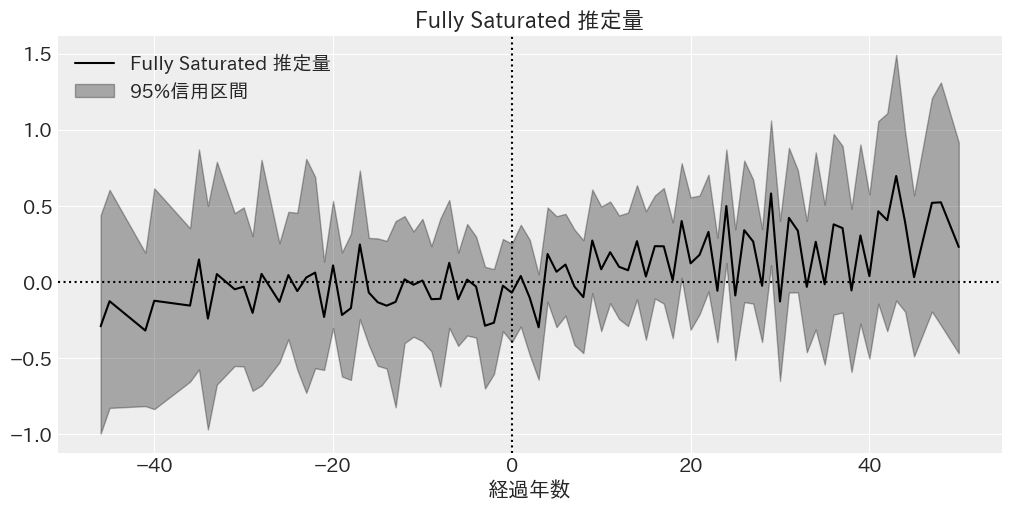

In [281]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x='ell', y='mean', data=fs_df, ax=ax, color='k', label='Fully Saturated 推定量')
ax.fill_between(
    x='ell',
    y1='hdi_lw',
    y2='hdi_up',
    data=fs_df,
    alpha=0.3,
    color='k',
    label='95%信用区間'
)
ax.set_title('Fully Saturated 推定量')
ax.set_xlabel('経過年数')
ax.set_ylabel('')
ax.axvline(x=0, color='k', linestyle=':')
ax.axhline(y=0, color='k', linestyle=':')
ax.legend()
plt.savefig('../../docs/figures/fully_saturated_twfe/ATT.png', bbox_inches='tight')

### 介入前の効果

In [305]:
# 介入前の推定量
negative_columns = [col for col in beta_ell_df.columns if re.search(r'ell_-\d+\.\d+', col)]
beta_ell_df_pre = beta_ell_df[negative_columns]

total_elements_pre = beta_ell_df_pre.size
positive_elements_pre = (beta_ell_df_pre > 0).sum().sum()
positive_ratio_pre = positive_elements_pre / total_elements_pre
print(f'介入前で正の確率: {positive_ratio_pre:.3%}')

beta_ell_df_pre_10 = beta_ell_df_pre.iloc[:, 28:-1]
total_elements_pre_10 = beta_ell_df_pre_10.size
positive_elements_pre_10 = (beta_ell_df_pre_10 > 0).sum().sum()
positive_ratio_pre_10 = positive_elements_pre_10 / total_elements_pre_10
print(f'介入前10年間で正の確率: {positive_ratio_pre_10:.3%}')

beta_ell_df_pre_20 = beta_ell_df_pre.iloc[:, 18:-1]
total_elements_pre_20 = beta_ell_df_pre_20.size
positive_elements_pre_20 = (beta_ell_df_pre_20 > 0).sum().sum()
positive_ratio_pre_20 = positive_elements_pre_20 / total_elements_pre_20
print(f'介入前20年間で正の確率: {positive_ratio_pre_20:.3%}')

beta_ell_df_pre_30 = beta_ell_df_pre.iloc[:, 9:-1]
total_elements_pre_30 = beta_ell_df_pre_30.size
positive_elements_pre_30 = (beta_ell_df_pre_30 > 0).sum().sum()
positive_ratio_pre_30 = positive_elements_pre_30 / total_elements_pre_30
print(f'介入前30年間で正の確率: {positive_ratio_pre_30:.3%}')

beta_ell_df_pre_40 = beta_ell_df_pre.iloc[:, 3:-1]
total_elements_pre_40 = beta_ell_df_pre_40.size
positive_elements_pre_40 = (beta_ell_df_pre_40 > 0).sum().sum()
positive_ratio_pre_40 = positive_elements_pre_40 / total_elements_pre_40
print(f'介入前40年間で正の確率: {positive_ratio_pre_40:.3%}')


介入前で正の確率: 38.574%
介入前10年間で正の確率: 35.713%
介入前20年間で正の確率: 38.697%
介入前30年間で正の確率: 39.393%
介入前40年間で正の確率: 39.878%


### 介入後の効果

In [271]:
# 介入前の推定量
negative_columns = [col for col in beta_ell_df.columns if re.search(r'ell_-\d+\.\d+', col)]
# 介入後の推定量
beta_ell_df_post = beta_ell_df.drop(columns=negative_columns)

beta_ell_df_post_10 = beta_ell_df_post.iloc[:, :11]

total_elements_post_10 = beta_ell_df_post_10.size
positive_elements_post_10 = (beta_ell_df_post_10 > 0).sum().sum()
positive_ratio_post_10 = positive_elements_post_10 / total_elements_post_10
print(f'介入後10年間で正の確率: {positive_ratio_post_10:.3%}')

beta_ell_df_post_20 = beta_ell_df_post.iloc[:, :21]

total_elements_post_20 = beta_ell_df_post_20.size
positive_elements_post_20 = (beta_ell_df_post_20 > 0).sum().sum()
positive_ratio_post_20 = positive_elements_post_20 / total_elements_post_20
print(f'介入後20年間で正の確率: {positive_ratio_post_20:.3%}')

beta_ell_df_post_30 = beta_ell_df_post.iloc[:, :31]

total_elements_post_30 = beta_ell_df_post_30.size
positive_elements_post_30 = (beta_ell_df_post_30 > 0).sum().sum()
positive_ratio_post_30 = positive_elements_post_30 / total_elements_post_30
print(f'介入後30年間で正の確率: {positive_ratio_post_30:.3%}')

beta_ell_df_post_40 = beta_ell_df_post.iloc[:, :41]

total_elements_post_40 = beta_ell_df_post_40.size
positive_elements_post_40 = (beta_ell_df_post_40 > 0).sum().sum()
positive_ratio_post_40 = positive_elements_post_40 / total_elements_post_40
print(f'介入後40年間で正の確率: {positive_ratio_post_40:.3%}')

beta_ell_df_post_50 = beta_ell_df_post.iloc[:, :51]

total_elements_post_50 = beta_ell_df_post_50.size
positive_elements_post_50 = (beta_ell_df_post_50 > 0).sum().sum()
positive_ratio_post_50 = positive_elements_post_50 / total_elements_post_50
print(f'介入後50年間で正の確率: {positive_ratio_post_50:.3%}')

介入後10年で正の確率: 53.516%


In [10]:
beta_df = az.summary(trace_homo, var_names=['beta'], hdi_prob=0.95)
# 正規表現でbridge_yearとtime_since_treatmentを抽出
pattern = r'C\(bridge_year\)\[(\d+)\]:C\(time_since_treatment\)\[(-?\d+)\.0\]'
extracted = beta_df.index.str.extract(pattern)
extracted.index = beta_df.index
beta_df['bridge_year'] = extracted[0].astype(int)
beta_df['time_since_treatment'] = extracted[1].astype(int)
beta_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, beta[C(bridge_year)[2016]:C(time_since_treatment)[-46.0]] to beta[C(bridge_year)[1970]:C(time_since_treatment)[50.0]]
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mean                  250 non-null    float64
 1   sd                    250 non-null    float64
 2   hdi_2.5%              250 non-null    float64
 3   hdi_97.5%             250 non-null    float64
 4   mcse_mean             250 non-null    float64
 5   mcse_sd               250 non-null    float64
 6   ess_bulk              250 non-null    float64
 7   ess_tail              250 non-null    float64
 8   r_hat                 250 non-null    float64
 9   bridge_year           250 non-null    int64  
 10  time_since_treatment  250 non-null    int64  
dtypes: float64(9), int64(2)
memory usage: 23.4+ KB


In [81]:
beta_df = pd.read_csv('../../data/processed/fully_saturated/homo.csv')

In [82]:
beta_df = beta_df.sort_values(['bridge_year', 'time_since_treatment'])
beta_df = beta_df.rename(columns={'hdi_2.5%': 'hdi_lwr', 'hdi_97.5%': 'hdi_upr'})

In [121]:
beta_df.describe()

,mean,sd,hdi_lwr,hdi_upr,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,bridge_year,time_since_treatment
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.00000,250.0,250.000000,250.000000
mean,0.037648,0.372052,-0.689484,0.760040,0.005252,0.004300,5437.224000,5251.76000,1.0,1991.408000,3.832000
std,0.289265,0.059750,0.318896,0.305426,0.001767,0.001327,1169.824422,472.91756,0.0,13.463379,20.750859
min,-0.967000,0.298000,-1.870000,-0.227000,0.004000,0.003000,1295.000000,3221.00000,1.0,1970.000000,-46.000000
25%,-0.124500,0.358250,-0.832750,0.588000,0.005000,0.004000,5006.000000,5033.25000,1.0,1979.750000,-11.000000
50%,0.048000,0.367000,-0.683000,0.768500,0.005000,0.004000,5686.500000,5334.50000,1.0,1991.000000,3.000000
75%,0.207500,0.375000,-0.497250,0.927000,0.005000,0.004000,6061.000000,5544.00000,1.0,2000.000000,19.000000
max,0.924000,0.830000,0.163000,1.668000,0.027000,0.019000,8027.000000,6378.00000,1.0,2016.000000,50.000000


## スムージング

In [330]:
fs_df = pd.read_csv('../../data/processed/fully_saturated/weighted_beta_posterior_summary.csv')

In [331]:
# level (Smooth Trend)
ll = st.LevelTrendComponent(order=2)
# 観測誤差
er = st.MeasurementError()

mod = ll + er
ss_mod = mod.build()

The following parameters should be assigned priors inside a PyMC model block: 
	initial_trend -- shape: (2,), constraints: None, dims: ('trend_state',)
	sigma_trend -- shape: (2,), constraints: Positive, dims: ('trend_shock',)
	sigma_MeasurementError -- shape: (), constraints: Positive, dims: None
	P0 -- shape: (2, 2), constraints: Positive semi-definite, dims: ('state', 'state_aux')


In [332]:
with pm.Model(coords=ss_mod.coords) as model_smooth:
    # 初期値の分散
    P0_diag = pm.Gamma('P0_diag', alpha=2, beta=1, dims=['state'])
    P0 = pm.Deterministic('P0', pt.diag(P0_diag), dims=['state', 'state_aux'])
    
    # 初期値
    initial_trend = pm.Normal('initial_trend', sigma=1, dims=['trend_state'])
    
    # 状態変数の分散
    sigma_trend = pm.HalfCauchy('sigma_trend', beta=1, dims=['trend_shock'])
    sigma_MeasurementError = pm.HalfCauchy('sigma_MeasurementError', beta=1)
    
    
    ss_mod.build_statespace_graph(data=fs_df['mean'], mode='JAX')

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc_experimental/statespace/utils/data_tools.py:92: UserWarning: No time index found on the supplied data. A simple range index will be automatically generated.
  warnings.warn(NO_TIME_INDEX_WARNING)
/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc_experimental/statespace/utils/data_tools.py:74: UserWarning: No time index found on the supplied data. A simple range index will be automatically generated.
  warnings.warn(NO_TIME_INDEX_WARNING)


In [333]:
with model_smooth:
    trace_smoothing = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        cores=4,
        nuts_sampler='numpyro',
        random_seed=42,
        target_accept=.998
    )

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [334]:
az.to_netcdf(trace_smoothing, './mcmc_sample/fully_saturated/smoothing_20250113.nc')

'./mcmc_sample/fully_saturated/smoothing_20250113.nc'

In [335]:
az.summary(trace_smoothing, hdi_prob=0.95)

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
initial_trend[level],-0.058,0.756,-1.546,1.428,0.010,0.009,5931.0,5070.0,1.0
initial_trend[trend],-0.009,0.750,-1.543,1.459,0.010,0.010,6021.0,4793.0,1.0
P0_diag[level],1.727,1.303,0.041,4.275,0.015,0.011,6245.0,3702.0,1.0
P0_diag[trend],1.706,1.281,0.019,4.147,0.015,0.011,5546.0,4170.0,1.0
sigma_trend[level],0.016,0.012,0.000,0.040,0.000,0.000,4091.0,2328.0,1.0
sigma_trend[trend],0.002,0.002,0.000,0.006,0.000,0.000,5835.0,2961.0,1.0
sigma_MeasurementError,0.170,0.014,0.144,0.197,0.000,0.000,6967.0,5404.0,1.0
"P0[level, level]",1.727,1.303,0.041,4.275,0.015,0.011,6245.0,3702.0,1.0
"P0[level, trend]",0.000,0.000,0.000,0.000,0.000,0.000,8000.0,8000.0,NaN
"P0[trend, level]",0.000,0.000,0.000,0.000,0.000,0.000,8000.0,8000.0,NaN


/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


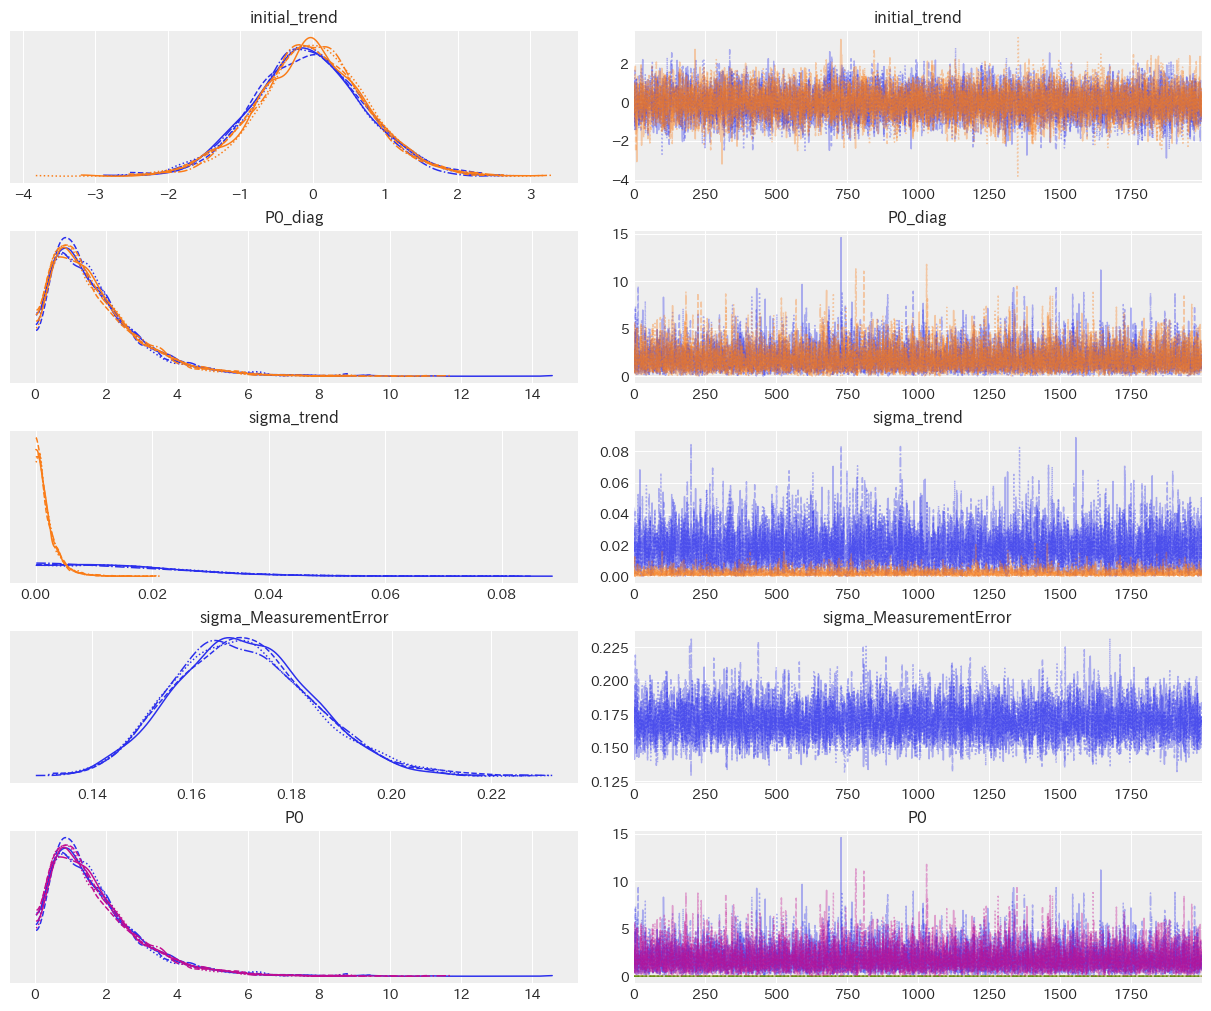

In [336]:
az.plot_trace(trace_smoothing);

In [337]:
post = ss_mod.sample_conditional_posterior(trace_smoothing)

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc_experimental/statespace/utils/data_tools.py:92: UserWarning: No time index found on the supplied data. A simple range index will be automatically generated.
  warnings.warn(NO_TIME_INDEX_WARNING)
/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc_experimental/statespace/utils/data_tools.py:74: UserWarning: No time index found on the supplied data. A simple range index will be automatically generated.
  warnings.warn(NO_TIME_INDEX_WARNING)
/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x7F278EA53D80>), RNG(<Generator(PCG64) at 0x7F278EA52EA0>), RNG(<Generator(PCG64) at 0x7F278E19ACE0>), RNG(<Generator(PCG64) at 0x7F278E19AF80>), RNG(<Generator(PCG64) at 0x7F278E19B5A0>), RNG(<Generator(PCG64) at 0x7F278DED6260>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  wa

Output()

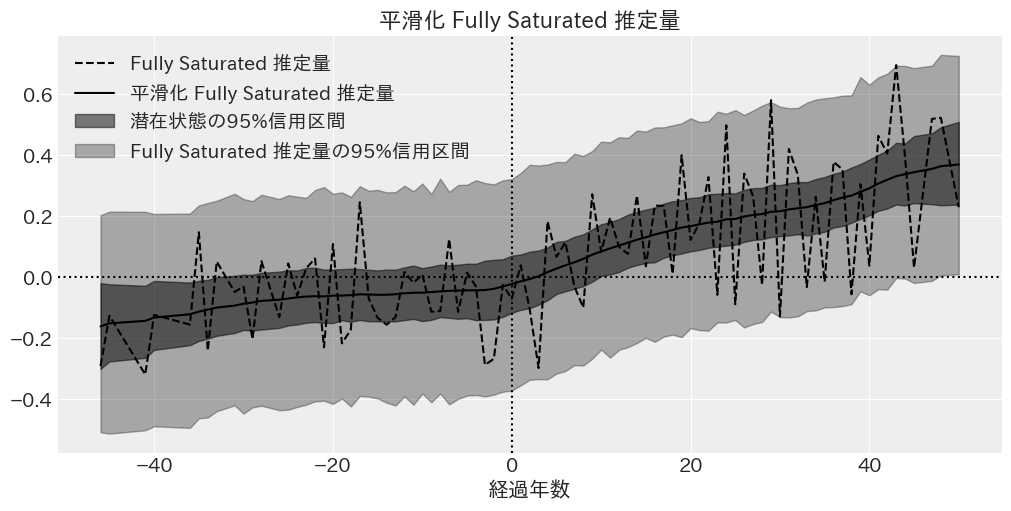

In [339]:
fig, ax = plt.subplots(figsize=(10, 5))

# 状態
data = post.smoothed_posterior.isel(state=0)
fs_df['smoothed_mean'] = data.mean(dim=['chain', 'draw']).values
hdi = az.hdi(data, hdi_prob=.95).smoothed_posterior
fs_df['state_smoothed_lwr_post'] = hdi[:len(fs_df), 0]
fs_df['state_smoothed_upr_post'] = hdi[:len(fs_df), 1]

# 観測
post_stacked = post.stack(sample=['chain', 'draw'])
hdi_post = az.hdi(post, hdi_prob=0.95).smoothed_posterior_observed.squeeze().values
fs_df['obs_smoothed_lwr_post'] = hdi_post[:, 0]
fs_df['obs_smoothed_upr_post'] = hdi_post[:, 1]

# sns.scatterplot(x='ell', y='mean', data=fs_df, ax=ax, color='black', label='事後期待値')
sns.lineplot(x='ell', y='mean', data=fs_df, ax=ax, color='black', label='Fully Saturated 推定量', ls='--')
ax.plot(
    fs_df['ell'],
    fs_df['smoothed_mean'],
    label='平滑化 Fully Saturated 推定量',
    color='k',
)
ax.fill_between(
    fs_df['ell'],
    y1=fs_df['state_smoothed_lwr_post'],
    y2=fs_df['state_smoothed_upr_post'],
    alpha=0.5, label='潜在状態の95%信用区間', color='k'
)
ax.fill_between(
    fs_df['ell'],
    y1=fs_df['obs_smoothed_lwr_post'],
    y2=fs_df['obs_smoothed_upr_post'],
    alpha=0.3, label='Fully Saturated 推定量の95%信用区間', color='k'
)
ax.axvline(x=0, color='k', linestyle=':')
ax.axhline(y=0, color='k', linestyle=':')
ax.set_title('平滑化 Fully Saturated 推定量')
ax.set_xlabel('経過年数')
ax.set_ylabel('')
ax.legend()
path = '../../docs/figures/fully_saturated_twfe/smoothed_ATT.png'
plt.savefig(path)

In [141]:
path = '../../data/processed/fully_saturated/weighted_beta_smoothed.csv'
weighted_beta_df.to_csv(path)

## 年効果

In [13]:
year_effects = az.summary(trace_homo, var_names=['year_effect'], hdi_prob=.95)

In [14]:
pattern = r'year_effect\[C\(year\)\[(\d+)\]\]'
extracted = year_effects.index.str.extract(pattern)
extracted.index = year_effects.index
year_effects['year'] = extracted[0].astype(int)


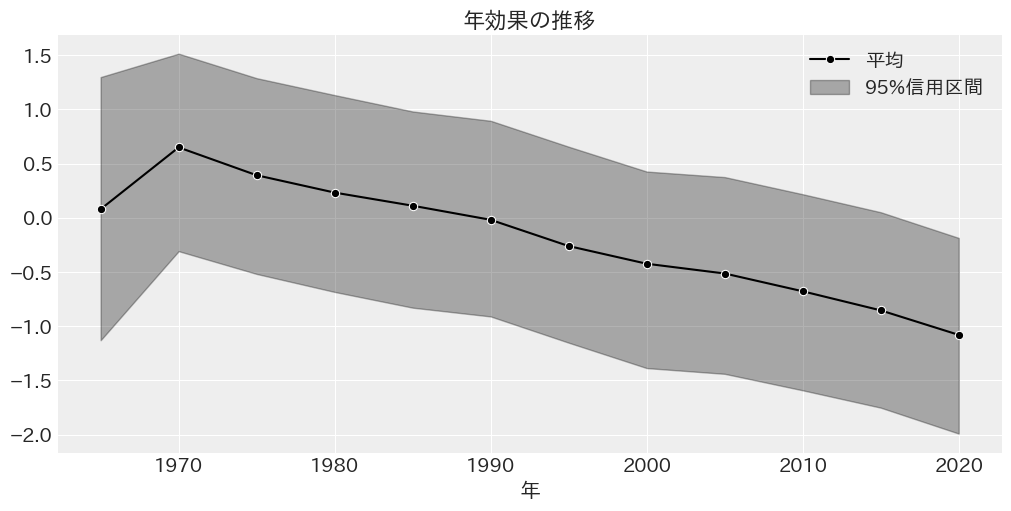

In [15]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x='year', y='mean', data=year_effects, ax=ax, marker='o', color='black', label='平均')
ax.fill_between(
    x='year',
    y1='hdi_2.5%',
    y2='hdi_97.5%',
    data=year_effects,
    color='black',
    alpha=0.3,
    label='95%信用区間'
)
ax.set_title('年効果の推移')
ax.set_xlabel('年')
ax.set_ylabel('')
ax.legend()

## サンプリングの保存

In [ ]:
az.to_netcdf(trace_h_hetero, './mcmc_sample/fully_saturated/trace_h_hetero.nc')
# az.to_netcdf(trace_h_homo, './mcmc_sample/fully_saturated/trace_h_homo.nc')

In [ ]:
trace_h_hetero = az.from_netcdf('./mcmc_sample/fully_saturated/hie_hetero.nc')